In [10]:
conda install geopandas

Channels:
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - geopandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.6.0               |  py312hca03da5_0          48 KB
    ca-certificates-2025.2.25  |       hca03da5_0         131 KB
    cairo-1.16.0               |       h302bd0f_5         1.0 MB
    certifi-2025.1.31          |  py312hca03da5_0         164 KB
    conda-24.11.3              |  py312hca03da5_0         1.2 MB
    folium-0.14.0              |  py312hca03da5_0         124 KB
    fontconfig-2.14.1          |       h6402c1e_3         252 KB
    freexl-2.0.0               |       ha3de405_0          52 KB
    geopandas-1.0.1            |  py312hca03da5_0         1.5 MB
    geopandas-base-1.0.1       |  py312hca03da5_0         2.2 MB
    geos-3.9.1                 |  

In [12]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Read the full state file
mn_tracts = gpd.read_file('tl_2024_27_tract.zip')

# Filter for Hennepin County (FIPS code 053)
hennepin_tracts = mn_tracts[mn_tracts['COUNTYFP'] == '053']

# Save just Hennepin County if you want
hennepin_tracts.to_file('hennepin_tracts.shp')

### Mortgage data from 2023

We now reading the mortgage data for Minnesota in 2023.

[https://ffiec.cfpb.gov/data-browser/data/2023?category=states&items=MN](https://ffiec.cfpb.gov/data-browser/data/2023?category=states&items=MN)

Data is available back to 2018.

In [29]:
mortgage_data = pd.read_csv('state_MN.csv')
mheaders = mortgage_data.columns
mheaders

/var/folders/lt/p6lwj8pj7vgcbcr0ylpxl6940000gn/T/ipykernel_68527/83746537.py:1: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,44) have mixed types. Specify dtype option on import or set low_memory=False.
  mortgage_data = pd.read_csv('state_MN.csv')


Index(['activity_year', 'lei', 'derived_msa-md', 'state_code', 'county_code',
       'census_tract', 'conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'derived_ethnicity', 'derived_race',
       'derived_sex', 'action_taken', 'purchaser_type', 'preapproval',
       'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open-end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'hoepa_status', 'total_loan_costs', 'total_points_and_fees',
       'origination_charges', 'discount_points', 'lender_credits', 'loan_term',
       'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization',
       'interest_only_payment', 'balloon_payment',
       'other_nonamortizing_features', 'property_value', 'construction_method',
       'occupancy_type', 'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'total_

In [30]:
# data set size
mortgage_data.shape

(174738, 99)

### We will filter the loans to only be mortgages.

[https://ffiec.cfpb.gov/documentation/publications/loan-level-datasets/lar-data-fields](https://ffiec.cfpb.gov/documentation/publications/loan-level-datasets/lar-data-fields)

This is loan_purpose == 1

In [32]:
# filter by loan_purpose = 1 (home purchase)
mortgage_data = mortgage_data[mortgage_data['loan_purpose'] == 1]

In [33]:
covenent = pd.read_csv('Hennepin_County_Racial_Covenants_Table.csv')
cheaders = covenent.columns
cheaders

Index(['FID', 'Doc_ID', 'Deed_ID', 'Racial_Res', 'Type_Res', 'Addition',
       'City', 'Block', 'Lot', 'Grantor', 'Grantee', 'Date_Deed', 'Date_Ex',
       'Ex_Year', 'Join_ID', 'Workflow', 'Rel_Score', 'X', 'Y', 'Address',
       'Distance'],
      dtype='object')

In [34]:
# make data set more manageable
covenant_slim = covenent[['FID', 'Racial_Res', 'Date_Deed', 'X', 'Y']]

In [35]:
mortgage_slim = mortgage_data[[
    'activity_year',
    'census_tract',
    'derived_race',
    'action_taken',
    'loan_amount',
    'property_value',
    'income',
    'interest_rate',
    'tract_minority_population_percent',
    'tract_to_msa_income_percentage',
    'denial_reason-1'
]]

### Merge the two data sets

Merging the two datasets is tricky because this is geographic data.  One data set uses Lat and Long.  The other is set up to use census data tracts.  To put this together, we need to convert Lat and Long into UTM coordinates and determine what is inside the tract boundary.

In [37]:
# Convert covenant data to GeoDataFrame with correct initial CRS
geometry = [Point(xy) for xy in zip(covenant_slim['X'], covenant_slim['Y'])]
covenant_gdf = gpd.GeoDataFrame(covenant_slim, geometry=geometry)
covenant_gdf.set_crs(epsg=4326, inplace=True)  # WGS84 decimal degrees

print("Original covenant points:", len(covenant_gdf))

# Transform to match the tracts CRS (UTM Zone 15N)
covenant_gdf = covenant_gdf.to_crs(epsg=26915)

# Quick check of transformed coordinates
print("\nTransformed coordinate ranges:")
print("X range:", covenant_gdf.geometry.x.min(), "to", covenant_gdf.geometry.x.max())
print("Y range:", covenant_gdf.geometry.y.min(), "to", covenant_gdf.geometry.y.max())

# Verify these points fall within tract bounds
tract_bounds = hennepin_tracts.total_bounds
print("\nTract bounds:")
print("X range:", tract_bounds[0], "to", tract_bounds[2])
print("Y range:", tract_bounds[1], "to", tract_bounds[3])

# Perform spatial join with transformed coordinates
covenants_with_tracts = gpd.sjoin(covenant_gdf, hennepin_tracts, how='left', predicate='within')

# See how many points matched to tracts
print("\nPoints that matched to tracts:", len(covenants_with_tracts))
print("Points with null tract assignments:", covenants_with_tracts['TRACTCE'].isna().sum())

# Count covenants per tract
covenants_per_tract = covenants_with_tracts.dropna(subset=['TRACTCE']).groupby('TRACTCE').size().reset_index(name='covenant_count')

print("\nTract Summary:")
print("Number of tracts with covenants:", len(covenants_per_tract))
if len(covenants_per_tract) > 0:
    print("\nCovenant counts per tract:")
    print(covenants_per_tract['covenant_count'].describe())

Original covenant points: 24119

Transformed coordinate ranges:
X range: 446281.946653618 to 483902.6287368457
Y range: 4960740.396902054 to 5002300.463783714

Tract bounds:
X range: -93.768385 to -93.177218
Y range: 44.785106 to 45.246618

Points that matched to tracts: 24119
Points with null tract assignments: 24119

Tract Summary:
Number of tracts with covenants: 0


/var/folders/lt/p6lwj8pj7vgcbcr0ylpxl6940000gn/T/ipykernel_68527/204365392.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:26915
Right CRS: EPSG:4269

  covenants_with_tracts = gpd.sjoin(covenant_gdf, hennepin_tracts, how='left', predicate='within')


In [38]:
def format_census_tract(value):
    try:
        # First convert to string to handle any type
        tract_str = str(value)
        # Remove any decimal points and trailing zeros
        tract_str = tract_str.split('.')[0]
        return tract_str
    except Exception as e:
        print(f"Error processing value: {value}, Type: {type(value)}")
        raise e

# Create a clean copy and try the conversion
mortgage_clean = mortgage_slim.copy()
mortgage_clean['census_tract'] = mortgage_clean['census_tract'].astype(str)
mortgage_clean['census_tract'] = mortgage_clean['census_tract'].apply(format_census_tract)

# Let's see what we got
print("\nAfter cleaning:")
print(mortgage_clean['census_tract'].head())


After cleaning:
0    27037060737
2    27141030504
3    27023950400
4    27171100101
5    27159480100
Name: census_tract, dtype: object


In [39]:
# Clean mortgage data - first ensure we have strings
mortgage_clean = mortgage_slim.copy()
mortgage_clean['census_tract'] = mortgage_clean['census_tract'].astype(str)
mortgage_clean['census_tract'] = mortgage_clean['census_tract'].str.replace('.0', '')

# Clean mortgage data - first ensure we have strings
mortgage_clean = mortgage_slim.copy()
mortgage_clean['census_tract'] = mortgage_clean['census_tract'].astype(str)
mortgage_clean['census_tract'] = mortgage_clean['census_tract'].str.replace('.0', '')



# First format the covenant census tract IDs
covenants_with_tracts['census_tract'] = (
    covenants_with_tracts['STATEFP'] + 
    covenants_with_tracts['COUNTYFP'] + 
    covenants_with_tracts['TRACTCE']
)

# Create the per-tract counts
covenants_per_tract = covenants_with_tracts.groupby('census_tract').size().reset_index(name='covenant_count')

# Clean the mortgage data
mortgage_clean = mortgage_slim.copy()
mortgage_clean['census_tract'] = mortgage_clean['census_tract'].astype(str).str.replace('.0', '')

# Verify the formats match
print("Mortgage data examples:")
print(mortgage_clean['census_tract'].head())
print("\nCovenant data examples:")
print(covenants_per_tract['census_tract'].head())






# Merge the datasets
combined_data = mortgage_clean.merge(
    covenants_per_tract,
    on='census_tract',
    how='left'
)

# Fill NaN covenant counts with 0
combined_data['covenant_count'] = combined_data['covenant_count'].fillna(0)

# Basic Analysis
print("\nMerge Results:")
print("Total mortgage applications:", len(combined_data))
print("Applications in tracts with covenants:", (combined_data['covenant_count'] > 0).sum())
print("Unique tracts with covenants:", combined_data[combined_data['covenant_count'] > 0]['census_tract'].nunique())

# Calculate approval rates
combined_data['was_approved'] = combined_data['action_taken'].isin([1, 2])
covenant_areas = combined_data['covenant_count'] > 0

print("\nApproval Rates:")
print("Tracts with no covenants:", 
      combined_data[~covenant_areas]['was_approved'].mean())
print("Tracts with covenants:", 
      combined_data[covenant_areas]['was_approved'].mean())

Mortgage data examples:
0    27037060737
2    27141030504
3    27023950400
4    27171100101
5    27159480100
Name: census_tract, dtype: object

Covenant data examples:
Series([], Name: census_tract, dtype: object)

Merge Results:
Total mortgage applications: 100931
Applications in tracts with covenants: 0
Unique tracts with covenants: 0

Approval Rates:
Tracts with no covenants: 0.6646619968097017
Tracts with covenants: nan


In [40]:
combined_data.columns

Index(['activity_year', 'census_tract', 'derived_race', 'action_taken',
       'loan_amount', 'property_value', 'income', 'interest_rate',
       'tract_minority_population_percent', 'tract_to_msa_income_percentage',
       'denial_reason-1', 'covenant_count', 'was_approved'],
      dtype='object')

## Analysis

In [85]:
# Ensure numeric data types
combined_data['property_value'] = pd.to_numeric(combined_data['property_value'], errors='coerce')
combined_data['loan_amount'] = pd.to_numeric(combined_data['loan_amount'], errors='coerce')
combined_data['income'] = pd.to_numeric(combined_data['income'], errors='coerce')
combined_data['interest_rate'] = pd.to_numeric(combined_data['interest_rate'], errors='coerce')

# Drop rows with missing values for property value before plotting
filtered_data = combined_data.dropna(subset=['property_value'])

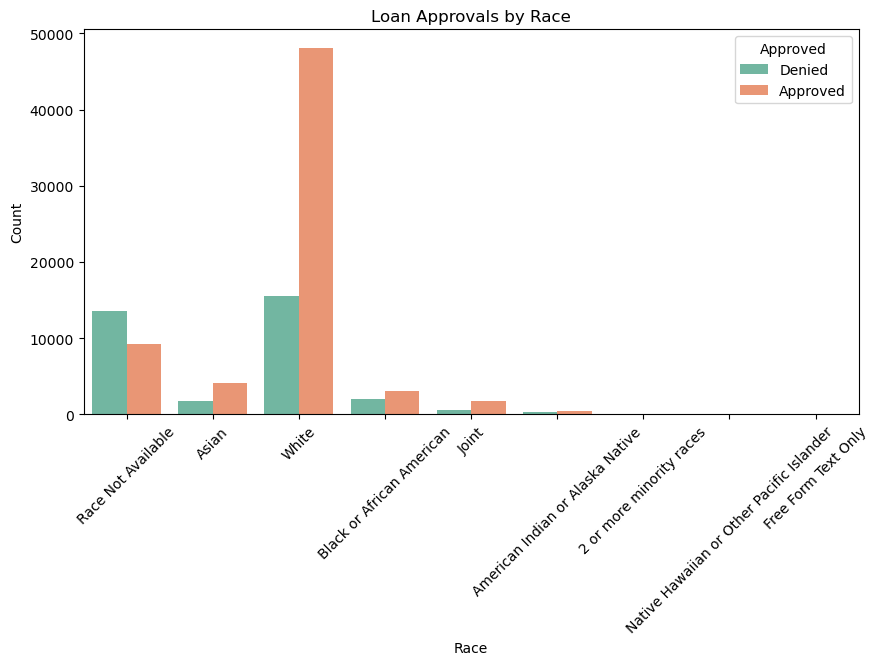

In [87]:
# Loan approvals by race
plt.figure(figsize=(10, 5))
sns.countplot(data=combined_data, x='derived_race', hue='was_approved', palette='Set2')
plt.title('Loan Approvals by Race')
plt.xticks(rotation=45)
plt.xlabel('Race')
plt.ylabel('Count')
plt.legend(title='Approved', labels=['Denied', 'Approved'])
plt.show()

### Interest rates by race

/var/folders/lt/p6lwj8pj7vgcbcr0ylpxl6940000gn/T/ipykernel_68527/2529789200.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='derived_race', y='interest_rate', palette='Set2')


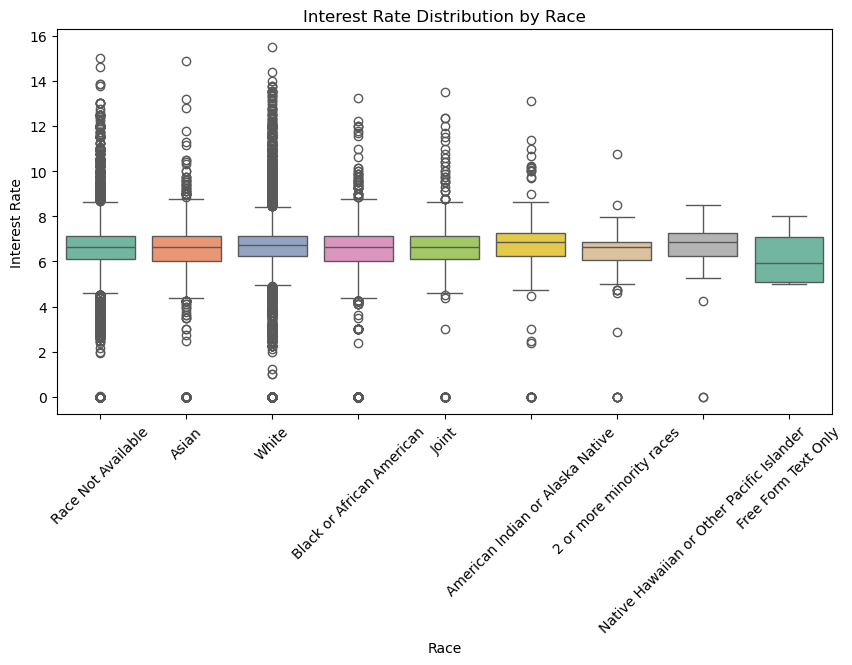

In [89]:
# Interest rates by race
plt.figure(figsize=(10, 5))
sns.boxplot(data=combined_data, x='derived_race', y='interest_rate', palette='Set2')
plt.title('Interest Rate Distribution by Race')
plt.xticks(rotation=45)
plt.xlabel('Race')
plt.ylabel('Interest Rate')
plt.show()

### Loan amounts by approval status

/var/folders/lt/p6lwj8pj7vgcbcr0ylpxl6940000gn/T/ipykernel_68527/2005738664.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='was_approved', y='loan_amount', palette='Set2')


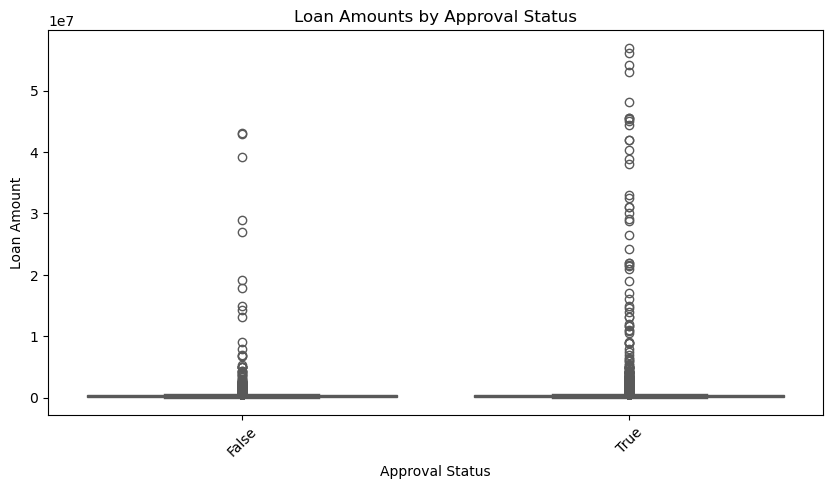

In [91]:
# Loan amounts by approval status
plt.figure(figsize=(10, 5))
sns.boxplot(data=combined_data, x='was_approved', y='loan_amount', palette='Set2')
plt.title('Loan Amounts by Approval Status')
plt.xlabel('Approval Status')
plt.ylabel('Loan Amount')
plt.xticks(rotation=45)
plt.show()

### Property value distribution by race

/var/folders/lt/p6lwj8pj7vgcbcr0ylpxl6940000gn/T/ipykernel_68527/1927122811.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='derived_race', y='property_value', palette='Set2')


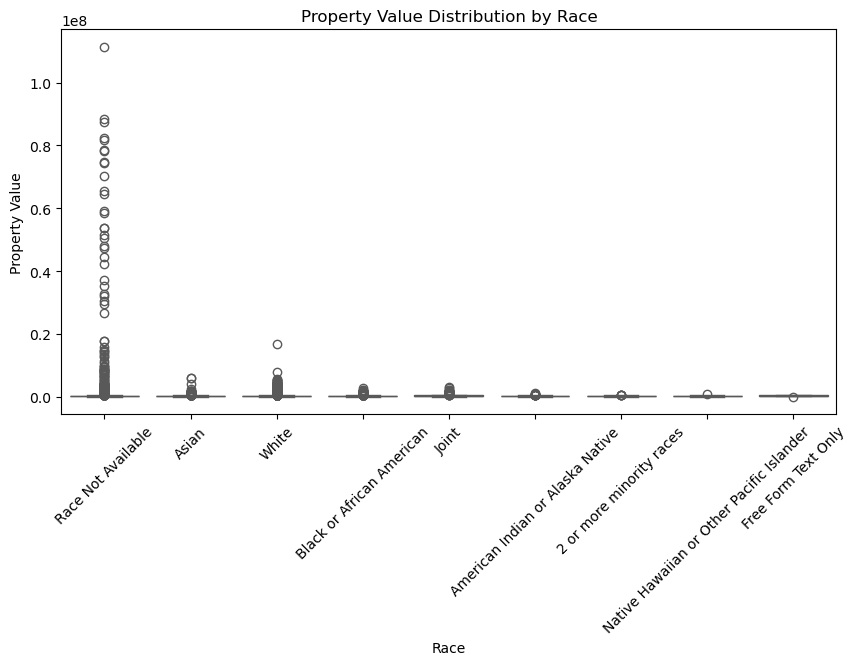

In [93]:
# Property value distribution by race
plt.figure(figsize=(10, 5))
sns.boxplot(data=combined_data, x='derived_race', y='property_value', palette='Set2')
plt.title('Property Value Distribution by Race')
plt.xticks(rotation=45)
plt.xlabel('Race')
plt.ylabel('Property Value')
plt.show()

### Interest rates by income level

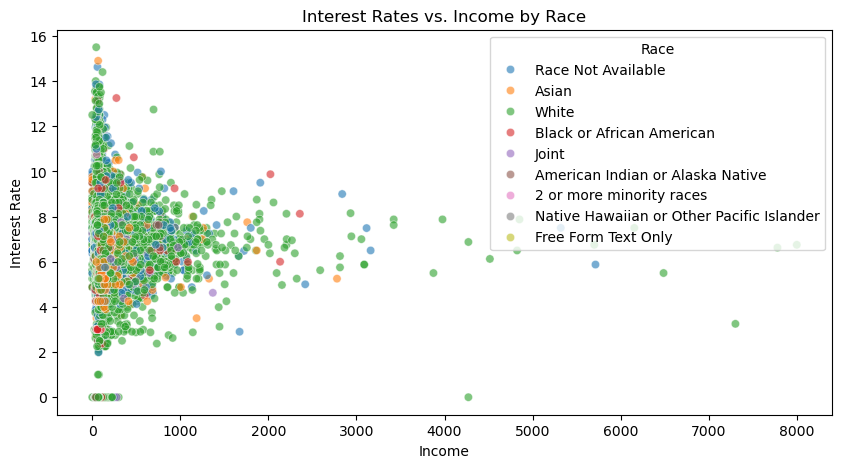

In [95]:
# Interest rates by income level
plt.figure(figsize=(10, 5))
sns.scatterplot(data=combined_data, x='income', y='interest_rate', hue='derived_race', alpha=0.6)
plt.title('Interest Rates vs. Income by Race')
plt.xlabel('Income')
plt.ylabel('Interest Rate')
plt.legend(title='Race')
plt.show()

### Minority population percentage vs. loan approvals

/var/folders/lt/p6lwj8pj7vgcbcr0ylpxl6940000gn/T/ipykernel_68527/858997025.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='was_approved', y='tract_minority_population_percent', palette='Set2')


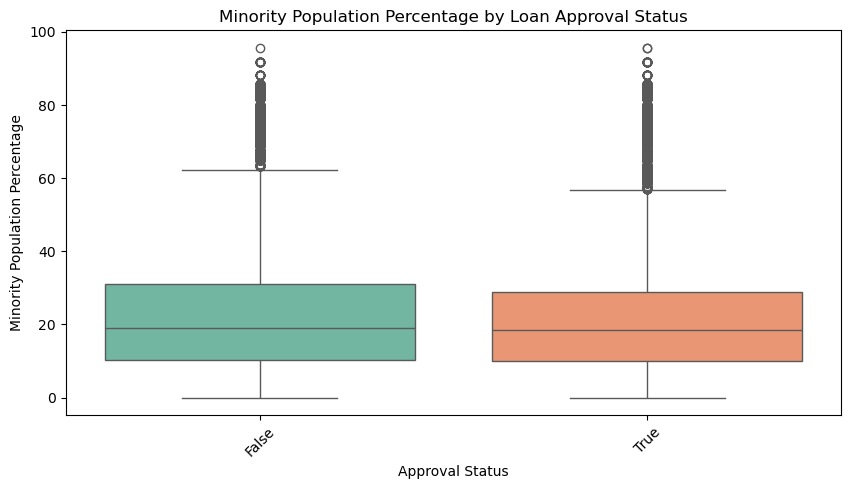

In [97]:
# Minority population percentage vs. loan approvals
plt.figure(figsize=(10, 5))
sns.boxplot(data=combined_data, x='was_approved', y='tract_minority_population_percent', palette='Set2')
plt.title('Minority Population Percentage by Loan Approval Status')
plt.xlabel('Approval Status')
plt.ylabel('Minority Population Percentage')
plt.xticks(rotation=45)
plt.show()

## NLP Analysis for denial reasons

In [110]:
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [112]:
# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sethphillips/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sethphillips/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

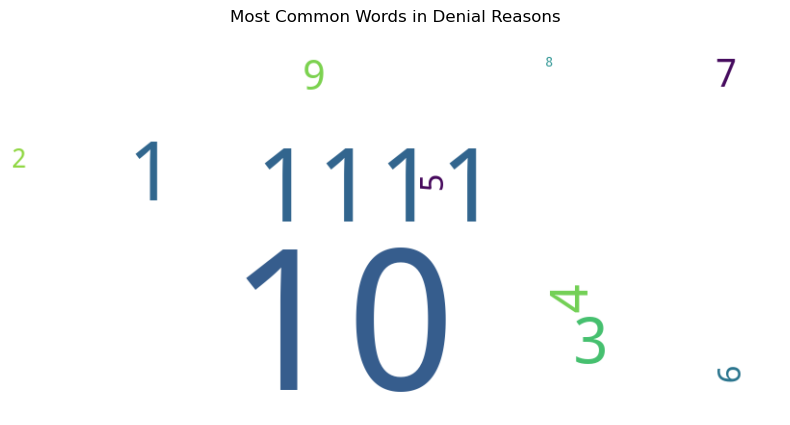

In [114]:
# NLP Analysis for denial reasons
def process_text(text_series):
    text = ' '.join(text_series.dropna().astype(str))
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stopwords.words('english')]
    return words

# Tokenizing and counting words
denial_words = process_text(combined_data['denial_reason-1'])
word_counts = Counter(denial_words)

# Generating Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Denial Reasons")
plt.show()

In [119]:
# Import data
df_covenant = pd.read_csv('mortgage_covenant_data.csv')
df_covenant.info()
df_covenant.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100931 entries, 0 to 100930
Data columns (total 14 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   activity_year                      100931 non-null  int64  
 1   census_tract                       99915 non-null   float64
 2   derived_race                       100931 non-null  object 
 3   action_taken                       100931 non-null  int64  
 4   loan_amount                        100931 non-null  float64
 5   property_value                     83491 non-null   float64
 6   income                             88200 non-null   float64
 7   interest_rate                      78125 non-null   float64
 8   tract_minority_population_percent  100931 non-null  float64
 9   tract_to_msa_income_percentage     100931 non-null  float64
 10  denial_reason-1                    100931 non-null  int64  
 11  covenant_count                     1009

,activity_year,census_tract,derived_race,action_taken,loan_amount,property_value,income,interest_rate,tract_minority_population_percent,tract_to_msa_income_percentage,denial_reason-1,covenant_count,was_approved,covenant_density
0,2023,2.703706e+10,Race Not Available,6,185000.0,195000.0,NaN,6.125,40.37,73.48,10,0.0,False,NaN
1,2023,2.714103e+10,Race Not Available,6,375000.0,385000.0,NaN,6.625,10.64,121.26,10,0.0,False,NaN


In [120]:
# Drop rows with race not available

df_covenant = df_covenant[df_covenant['derived_race'] != 'Race Not Available' ]

In [134]:
# Take counts of race based on covenant_density

df_race = df_covenant.groupby('covenant_density')['derived_race'].value_counts()
df_race = df_race.to_frame()
df_race.columns = ['count']
df_race.reset_index(inplace=True)


# Value count of derived_race in df
df_race_count = df_covenant['derived_race'].value_counts(dropna=False)
df_race_count = df_race_count.to_frame()
df_race_count.reset_index(inplace=True)
df_race_count.columns = ['derived_race', 'total_count']

# Now, merge using the 'derived_race' column
df_race = df_race.merge(df_race_count, on='derived_race', how='left')
df_race['normalized_count'] = df_race['count'] / df_race['total_count']
df_race["percentage"] = df_race["normalized_count"] * 100

<Figure size 1200x600 with 0 Axes>

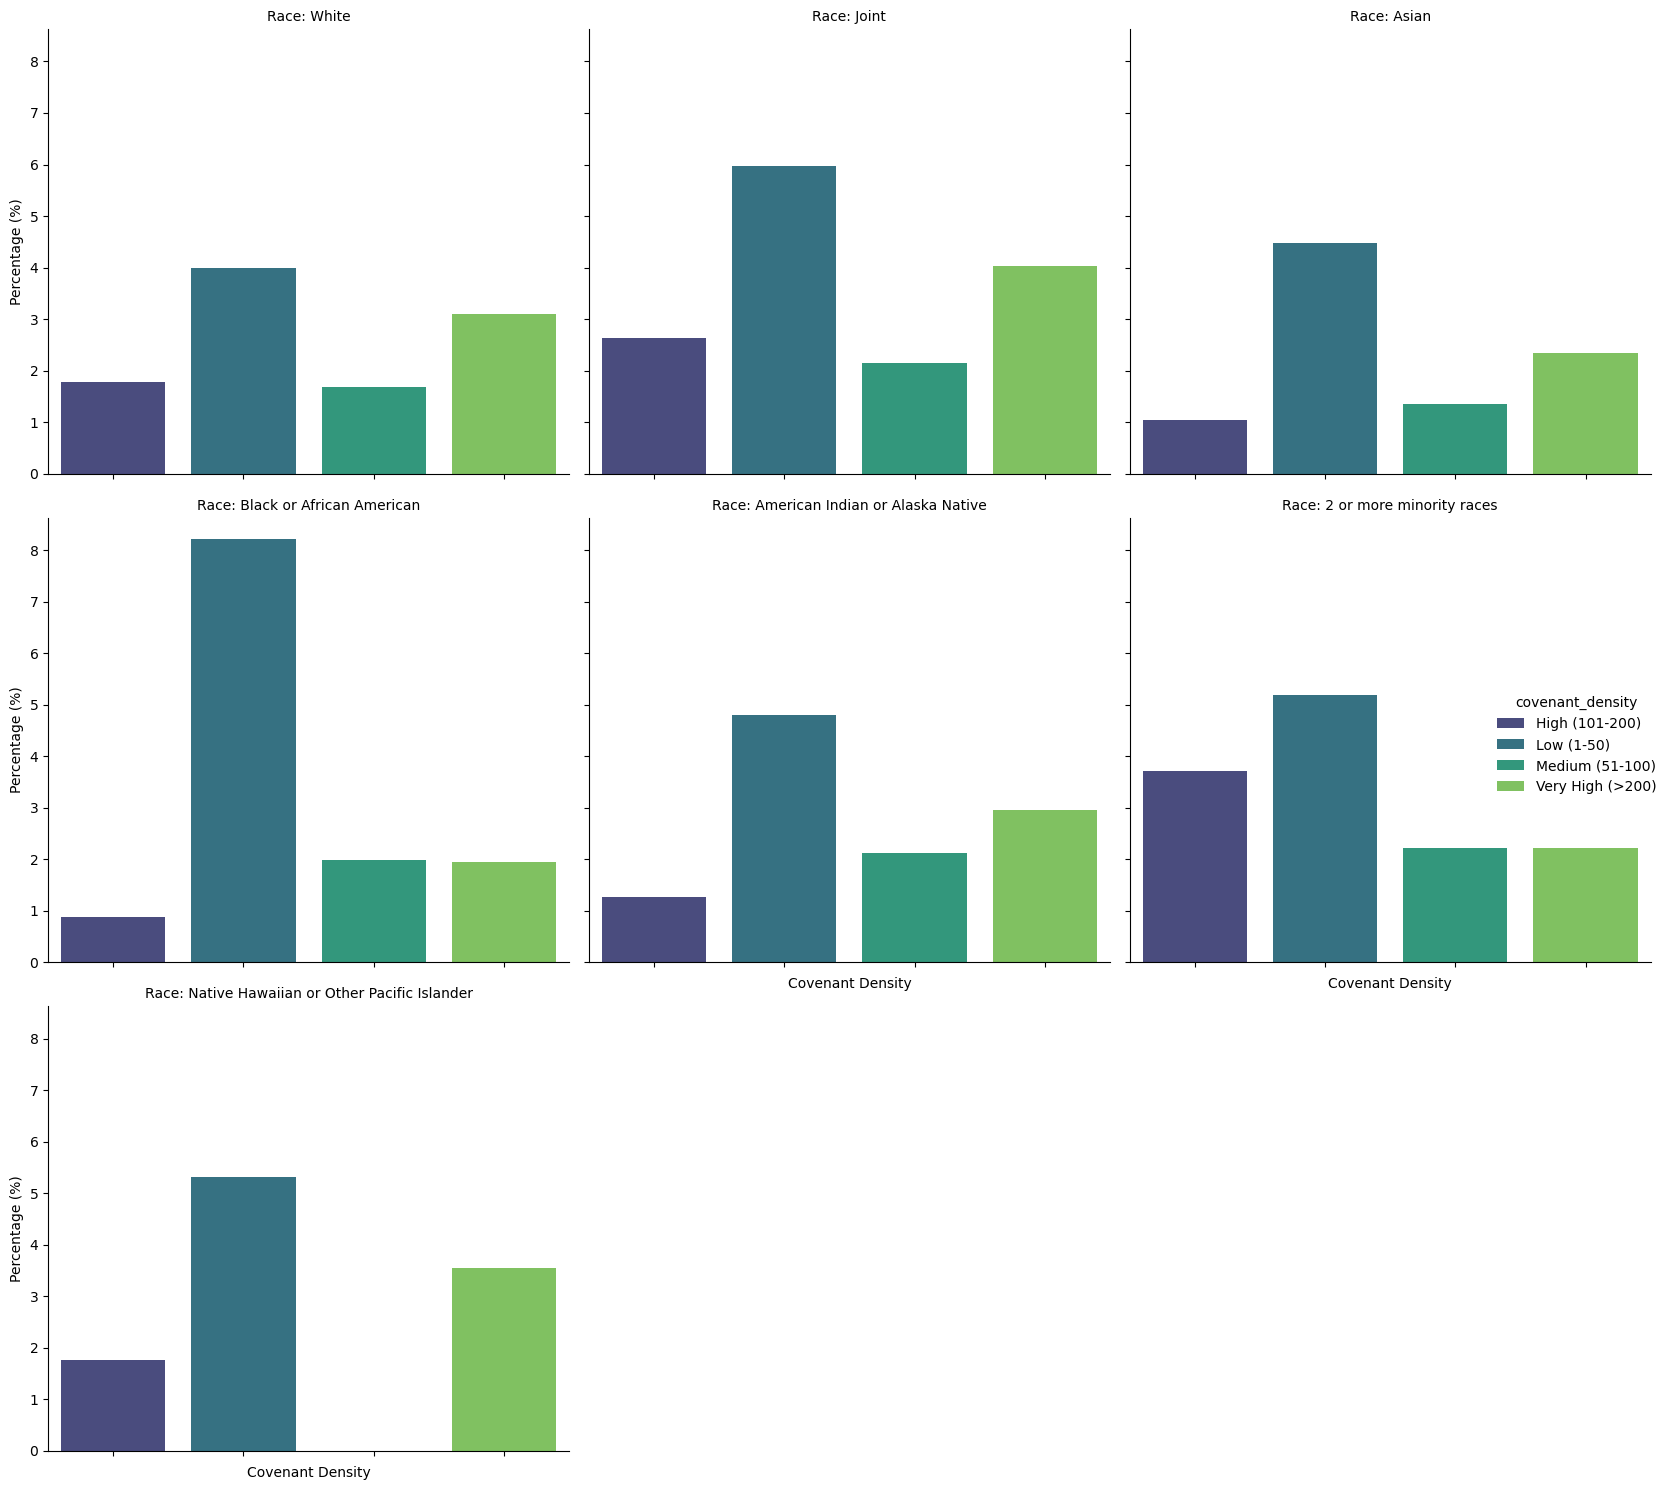

In [135]:
plt.figure(figsize=(12, 6))

# Create a categorical plot with subplots for each race
g = sns.catplot(
    data=df_race,
    x="covenant_density",
    y="percentage",
    hue="covenant_density",  # Hue differentiates bars
    col="derived_race",
    kind="bar",
    col_wrap=3,  # Adjust for better layout
    palette="viridis",  # Choose a clear color palette
    sharey=True,
    legend=True
)

# Rotate x-axis labels for readability
g.set_xticklabels(rotation=45)

# Set axis labels and titles
g.set_axis_labels("Covenant Density", "Percentage (%)")
g.set_titles("Race: {col_name}")

# Adjust layout
plt.tight_layout()
plt.show()


In [136]:
# Take counts of was_approved by race

df_approved = df_covenant.groupby('derived_race')['was_approved'].value_counts()
df_approved = df_approved.to_frame()
df_approved.columns = ['count']
df_approved.reset_index(inplace=True)

# Divide count by total number of people in race

df_approved_count = df_covenant.groupby('derived_race')['was_approved'].count()
df_approved_count = df_approved_count.to_frame()
df_approved_count.reset_index(inplace=True)
df_approved_count.columns = ['derived_race', 'total_count']
df_approved = df_approved.merge(df_approved_count, on='derived_race', how='left')
df_approved['normalized_count'] = df_approved['count'] / df_approved['total_count']
df_approved['percentage'] = df_approved['normalized_count'] * 100
df_approved

,derived_race,was_approved,count,total_count,normalized_count,percentage
0,2 or more minority races,True,89,135,0.659259,65.925926
1,2 or more minority races,False,46,135,0.340741,34.074074
2,American Indian or Alaska Native,True,441,709,0.622003,62.200282
3,American Indian or Alaska Native,False,268,709,0.377997,37.799718
4,Asian,True,4179,5905,0.707705,70.770533
5,Asian,False,1726,5905,0.292295,29.229467
6,Black or African American,True,3141,5199,0.604155,60.415465
7,Black or African American,False,2058,5199,0.395845,39.584535
8,Free Form Text Only,True,4,5,0.800000,80.000000
9,Free Form Text Only,False,1,5,0.200000,20.000000


Text(0.5, 1.0, 'Percentages of People in Each Race if they were Approved for a Mortgage')

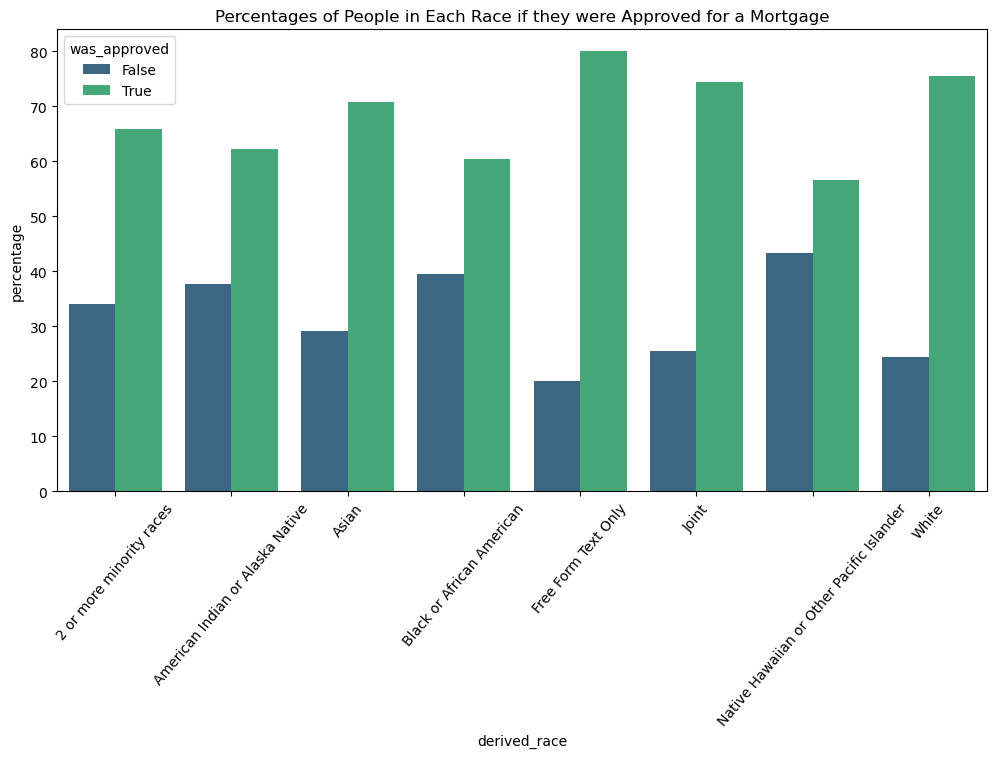

In [137]:
# Make bar chart of normalized percent and was_approved based on race

plt.figure(figsize=(12, 6))
sns.barplot(x='derived_race', y='percentage', data=df_approved, hue='was_approved', palette='viridis')
plt.xticks(rotation=50)
plt.title('Percentages of People in Each Race if they were Approved for a Mortgage')


In [138]:
# Create Dataframe without white people

df_minority = df_covenant[df_covenant['derived_race'] != 'White']

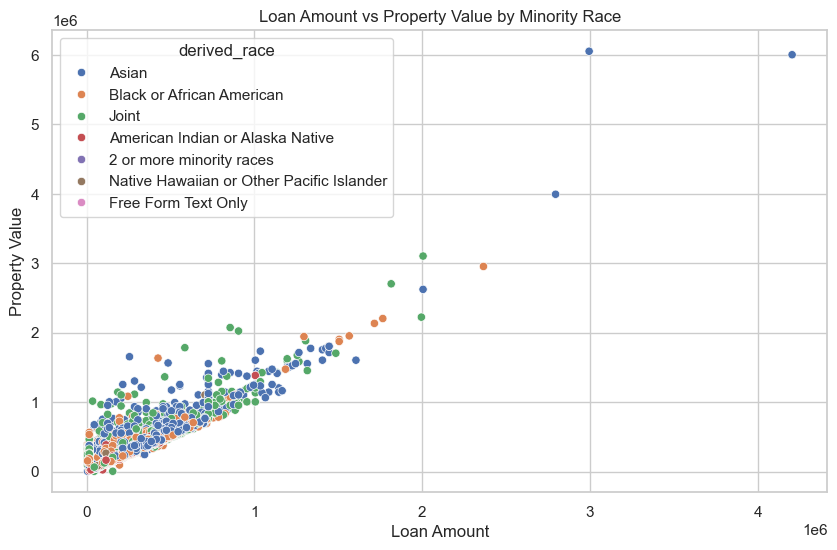

In [139]:
# Create plot of loan_amount vs	property_value hued by race

# Set the style

sns.set(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='loan_amount', y='property_value', hue='derived_race', data=df_minority, palette='deep')

# Add labels and title
plt.title('Loan Amount vs Property Value by Minority Race')
plt.xlabel('Loan Amount')
plt.ylabel('Property Value')

# Show the plot
plt.show()

In [140]:
# Eliminate NaN values for income
# Eliminate NaN values for income

df_low_income = df_covenant.dropna(subset=['income'])
df_low_income = df_low_income[(df_low_income['income'] < 500) & (df_low_income['income'] > 0)]

/var/folders/lt/p6lwj8pj7vgcbcr0ylpxl6940000gn/T/ipykernel_68527/2800725035.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='derived_race', y='tract_minority_population_percent', data=df_low_income, palette='muted', ax=axes[0])
/var/folders/lt/p6lwj8pj7vgcbcr0ylpxl6940000gn/T/ipykernel_68527/2800725035.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='derived_race', y='income', data=df_low_income, palette='muted', ax=axes[1])


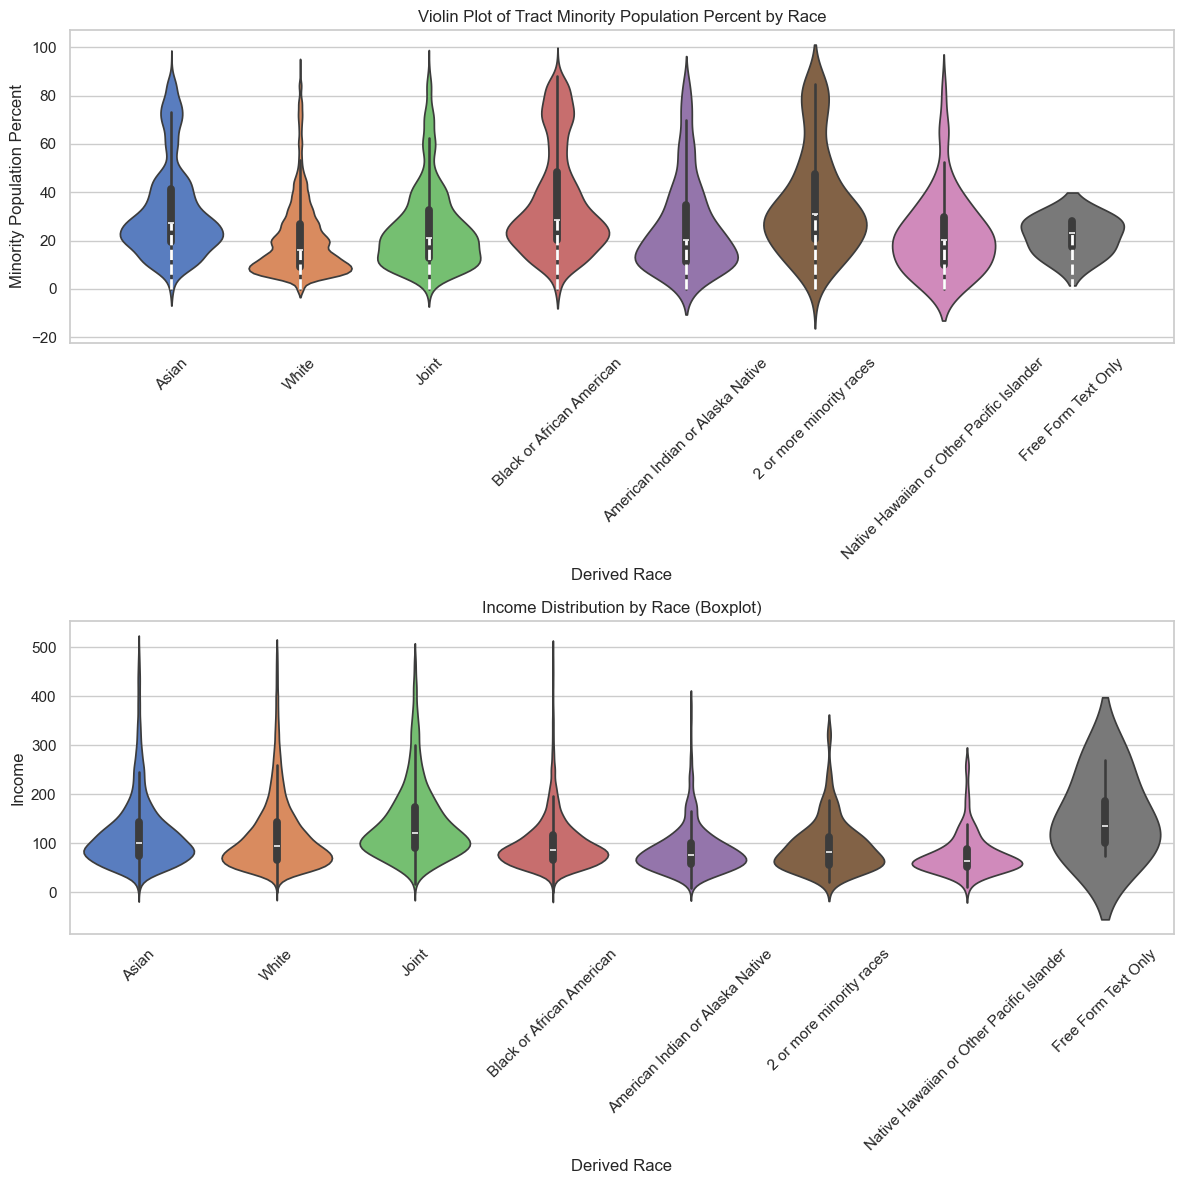

In [141]:
# Create plots

sns.set(style="whitegrid")

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the Violin plot for tract_minority_population_percent by derived_race
sns.violinplot(x='derived_race', y='tract_minority_population_percent', data=df_low_income, palette='muted', ax=axes[0])
axes[0].set_title('Violin Plot of Tract Minority Population Percent by Race')
axes[0].set_xlabel('Derived Race')
axes[0].set_ylabel('Minority Population Percent')
plt.setp(axes[0].get_xticklabels(), rotation=45)
for i in df_low_income['derived_race'].unique():
    median_val = df_low_income[df_low_income['derived_race'] == i]['tract_minority_population_percent'].median()
    axes[0].plot([i, i], [0, median_val], color='white', lw=2, ls='--')

# Plot the Boxplot for income by derived_race
sns.violinplot(x='derived_race', y='income', data=df_low_income, palette='muted', ax=axes[1])
axes[1].set_title('Income Distribution by Race (Boxplot)')
axes[1].set_xlabel('Derived Race')
axes[1].set_ylabel('Income')
plt.setp(axes[1].get_xticklabels(), rotation=45)
# Adjust the layout for better spacing
plt.tight_layout()

# Create vertical space between the subplots
plt.subplots_adjust(wspace=0.5)
# Show the plot
plt.show()

In [142]:
# Eliminate covenant_denisty from df

df_covenant.drop(columns='covenant_density', inplace = True)

In [143]:
# Dummy variables

df_covenant = pd.get_dummies(df_covenant, columns=['derived_race'], drop_first=False, dtype='int')
df_covenant = pd.get_dummies(df_covenant, columns=['activity_year'], drop_first=False, dtype='int')
df_covenant = pd.get_dummies(df_covenant, columns=['action_taken'], drop_first=False, dtype='int')

In [144]:
# Change was_approved values to binary

df_covenant['was_approved'] = df_covenant['was_approved'].map({'True': 1, 'False': 0})

In [145]:
# count nulls

df_covenant.isna().sum()

census_tract                                                831
loan_amount                                                   0
property_value                                            13469
income                                                      708
interest_rate                                             17962
tract_minority_population_percent                             0
tract_to_msa_income_percentage                                0
denial_reason-1                                               0
covenant_count                                                0
was_approved                                              78120
derived_race_2 or more minority races                         0
derived_race_American Indian or Alaska Native                 0
derived_race_Asian                                            0
derived_race_Black or African American                        0
derived_race_Free Form Text Only                              0
derived_race_Joint                      

In [146]:
# Eliminate nulls from property_value

df_covenant = df_covenant.dropna(subset=['property_value', 'interest_rate', 'income'])
df_covenant.head(2)

,census_tract,loan_amount,property_value,income,interest_rate,tract_minority_population_percent,tract_to_msa_income_percentage,denial_reason-1,covenant_count,was_approved,...,derived_race_White,activity_year_2023,action_taken_1,action_taken_2,action_taken_3,action_taken_4,action_taken_5,action_taken_6,action_taken_7,action_taken_8
65,2.713908e+10,525000.0,555000.0,277.0,5.750,25.71,144.96,10,0.0,NaN,...,1,1,1,0,0,0,0,0,0,0
70,2.705301e+10,665000.0,785000.0,182.0,8.625,41.44,15.77,10,0.0,NaN,...,1,1,1,0,0,0,0,0,0,0


## Regression on Property Value

In [148]:
X = df_covenant.drop(['census_tract', 'was_approved', 'property_value'], axis=1)
y = df_covenant['property_value']

In [149]:
import statsmodels.api as sm
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         property_value   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                 1.082e+04
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        19:42:55   Log-Likelihood:            -7.8570e+05
No. Observations:               59467   AIC:                         1.571e+06
Df Residuals:                   59450   BIC:                         1.572e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have your predictions in a dataframe called 'predictions'
# with columns 'race' and 'predicted_property_tax'

# Filter predictions for White and African American homeowners
white_predictions = results[results['race'] == 'White']
black_predictions = predictions[predictions['race'] == 'African American']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatterplot for White homeowners
sns.scatterplot(x=white_predictions.index, y=white_predictions['predicted_property_tax'], ax=axes[0])
axes[0].set_title('Predicted Property Taxes for White Homeowners')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Predicted Property Tax')

# Scatterplot for African American homeowners
sns.scatterplot(x=black_predictions.index, y=black_predictions['predicted_property_tax'], ax=axes[1])
axes[1].set_title('Predicted Property Taxes for African American Homeowners')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Predicted Property Tax')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

TypeError: 'RegressionResultsWrapper' object is not subscriptable

In [153]:
# Create a cleaned dataset by dropping rows with missing values
df_clean = df_covenant.dropna(subset=['property_value', 'income', 'interest_rate', 'loan_amount'])

In [164]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59467 entries, 65 to 100923
Data columns (total 27 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   census_tract                                            59286 non-null  float64
 1   loan_amount                                             59467 non-null  float64
 2   property_value                                          59467 non-null  float64
 3   income                                                  59467 non-null  float64
 4   interest_rate                                           59467 non-null  float64
 5   tract_minority_population_percent                       59467 non-null  float64
 6   tract_to_msa_income_percentage                          59467 non-null  float64
 7   denial_reason-1                                         59467 non-null  int64  
 8   covenant_count                         

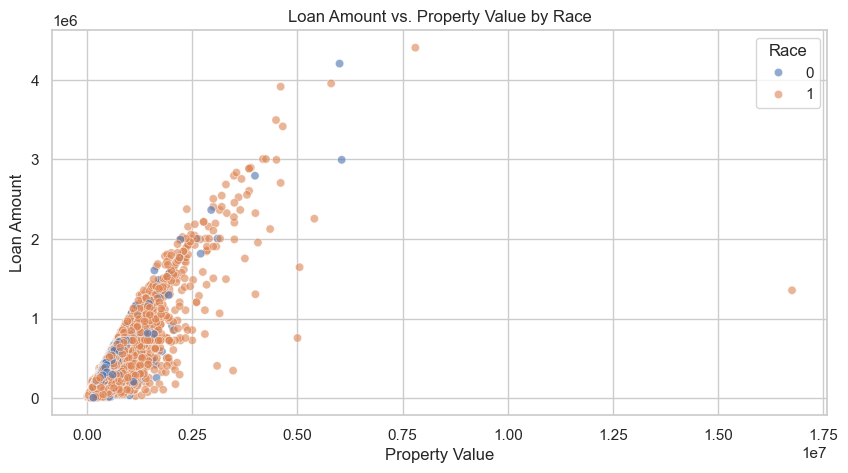

In [166]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_clean, x='property_value', y='loan_amount', hue='derived_race_White', alpha=0.6)
plt.title('Loan Amount vs. Property Value by Race')
plt.xlabel('Property Value')
plt.ylabel('Loan Amount')
plt.legend(title='Race')
plt.show()

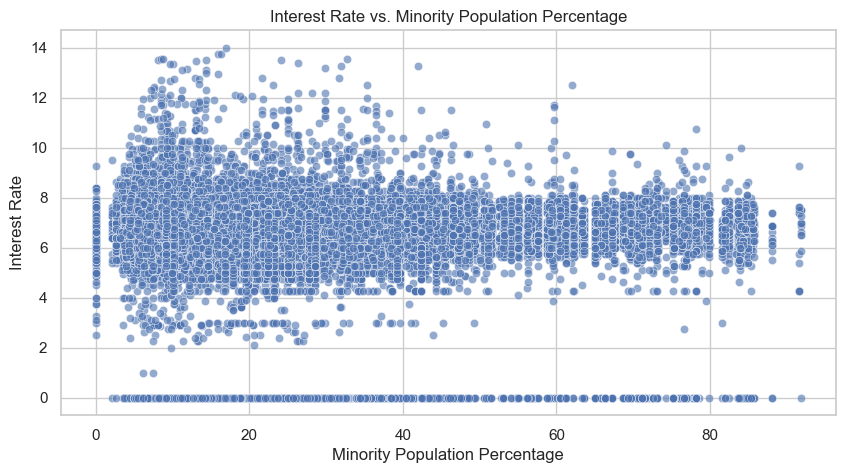

In [159]:
# Interest Rate vs. Minority Population Percentage
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_clean, x='tract_minority_population_percent', y='interest_rate', alpha=0.6)
plt.title('Interest Rate vs. Minority Population Percentage')
plt.xlabel('Minority Population Percentage')
plt.ylabel('Interest Rate')
plt.show()

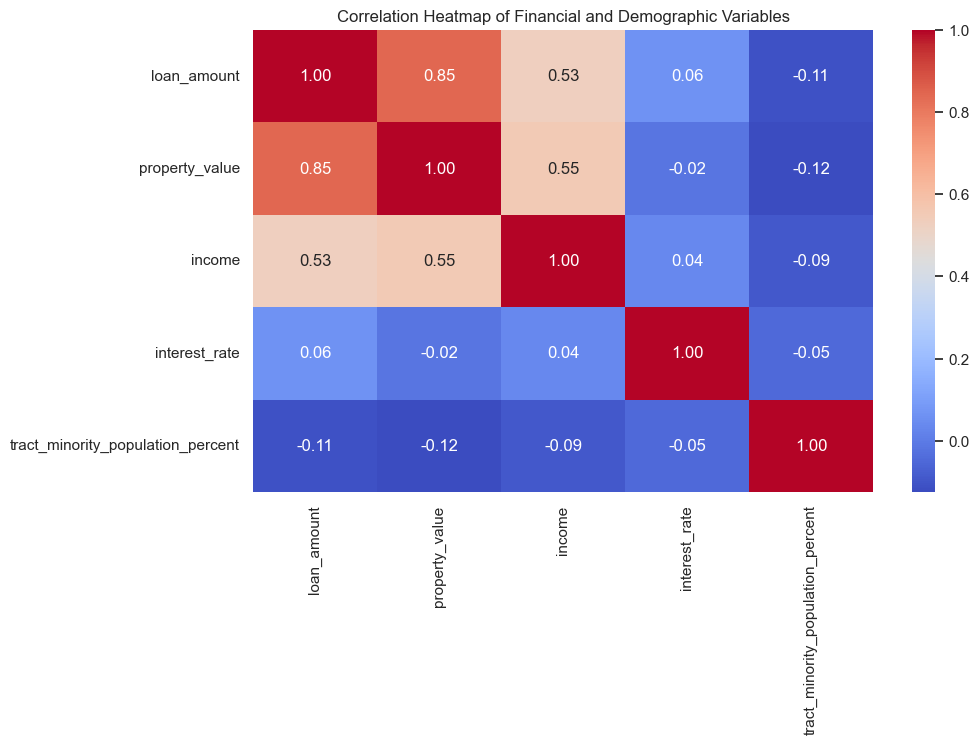

In [161]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
correlation_matrix = df_clean[['loan_amount', 'property_value', 'income', 'interest_rate', 'tract_minority_population_percent']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Financial and Demographic Variables')
plt.show()